In [1]:
import pysam
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from os import path
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc

In [48]:
def get_coverage(bam_path):
    with pysam.AlignmentFile(bam_path, 'rb') as alignment:
        assert(alignment.check_index())
        n_ref = len(alignment.references)
        coverages = []
        ref_lens = []
        for ref in alignment.references:
            ref_len = alignment.get_reference_length(alignment.references[0])
            curr_coverage = np.zeros(ref_len)
            positions = []
            for read in tqdm_notebook(alignment.fetch(ref)):
                curr_coverage[read.reference_start:read.reference_end] +=1
            coverages.append(curr_coverage)
        return coverages[0] if n_ref == 1 else coverages
    
def coverage_plot(coverage, bin_width=200, lab_step=4, k=1000):
    from math import ceil
    ref_len = len(coverage)
    cov_percent = len(coverage == 0)/ref_len*100
    mean_cov = round(np.mean(coverage), 3)
    l = ceil(ref_len/bin_width)
    to_plot = np.zeros(shape = l)
    labels = np.chararray(l, itemsize=11)
    rng = range(0, ref_len, bin_width)
    for i, j in enumerate(rng):
        to_plot[i] = np.mean(coverage[j:j+bin_width])
        labels[i] = f'{j//k}k-{(j+bin_width-1)//k}k'
    fig, ax = plt.subplots(figsize = [16, 9])
    ax.plot(rng, to_plot, 
            label=f'Mean coverage = {mean_cov}\nCoverage % = {cov_percent}\nBinsize = {bin_width}')
    ax.grid()
    ax.set_xlabel('Reference bp')
    ax.set_ylabel('Coverage')
    ax.set_title('Coverage plot')
    
    def decoder(x):
        return map(lambda el: el.decode(), x)

    ax.set_xticks(rng[::lab_step])
    ax.set_xticklabels(decoder(labels[::lab_step]))
    ax.legend()
    
def get_mean_error(bam_path):
    errs = []
    with pysam.AlignmentFile(bam_path, 'rb') as alf:
        for read in alf.fetch():
            if read.query_length != 0:
                curr = read.get_tag('NM')
                curr /= read.query_length
                errs.append(curr)
    return np.mean(errs)*100

def sub_indel_mat(bam_path, ref_path, alphabet=['A', 'C', 'G', 'T', '_']):
    sub_mat = pd.DataFrame(np.zeros((len(alphabet), len(alphabet))), index=alphabet, columns=alphabet)
    with pysam.AlignmentFile(bam_path, 'rb') as alignment, pysam.Fastafile(ref_path) as ref:
        for ref_contig in alignment.references:
            ref_str = ref.fetch(ref_contig)
            for read in tqdm_notebook(alignment.fetch(ref_contig)):
                start_flag = False
                for qi, ri in read.get_aligned_pairs():
                    if (qi != None):
                        if (qi == read.query_alignment_start): start_flag = True 
                    if (start_flag) and (read.seq != None):
                        if (qi == None) and (ref_str[ri].upper() in alphabet):
                            sub_mat.loc['_', ref_str[ri].upper()] += 1
                        elif (ri == None) and (read.seq[qi].upper() in alphabet):  
                            sub_mat.loc[read.seq[qi], '_'] += 1
                        elif (read.seq[qi] != ref_str[ri]) and (read.seq[qi] in alphabet)\
                              and (ref_str[ri].upper() in alphabet):
                            sub_mat.loc[read.seq[qi], ref_str[ri].upper()] +=1 
    return sub_mat

def indel_stat(bam_path):
    indel_lens = []
    with pysam.AlignmentFile(bam_path, 'rb') as alf:
        for read in alf.fetch():
            for reg in read.cigartuples:
                if (reg[0] == 1) or (reg[0] == 2):
                    indel_lens.append(reg[1])
    return indel_lens

def indel_stat_plot(indel_lens, step_size=20):
    fig, ax = plt.subplots(figsize=[16, 9])
    sns.distplot(indel_lens, kde=False, norm_hist=False)
    ax.set_xlabel('Indel length')
    ax.set_ylabel('Number of reads')
    ax.set_title('Indel length plot')
    ax.set_yscale('log')
    ax.legend()
    ax.grid()
    

Commands I've used to align reads to the reference are listed in the Command_Journals/Journal_3.txt

In [3]:
onp_bam_path = 'Data/Assignment_3/onp_al_s.bam'
pacb_bam_path = 'Data/Assignment_3/pacb_al_s.bam'
ref_path = 'Data/Assignment_3/reference.fasta'

## Oxford Nanopore data:

92.09% of reads mapped:

In [8]:
!samtools flagstat Data/Assignment_3/onp_al_s.bam

32103 + 0 in total (QC-passed reads + QC-failed reads)
1072 + 0 secondary
221 + 0 supplementary
0 + 0 duplicates
29565 + 0 mapped (92.09% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [6]:
cov_onp = get_coverage(onp_bam_path)
print(len(cov_onp))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


4639675


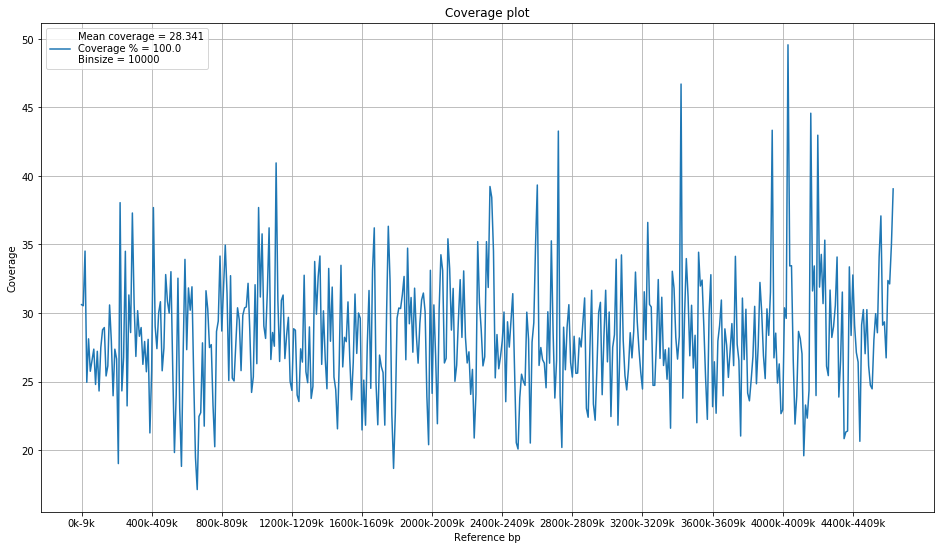

In [10]:
coverage_plot(cov_onp, bin_width=10000, lab_step=40)

In [57]:
print('Mean error percentage =', round(get_mean_error(onp_bam_path), 3), '%')

Mean error percentage = 8.028 %


In [25]:
%time !mpirun -np 4 python sub_indel_mat_parallel.py -b Data/Assignment_3/onp_al_s.bam -ref Data/Assignment_3/reference.fasta -o Data/Assignment_3/onp_subind.csv

CPU times: user 18.5 s, sys: 4.72 s, total: 23.2 s
Wall time: 13min 26s


In [27]:
pd.read_csv('Data/Assignment_3/onp_subind.csv', index_col=0)

,A,C,G,T,_
A,0.0,137046.0,319761.0,107765.0,706892.0
C,112963.0,0.0,91353.0,372780.0,662751.0
G,368487.0,85027.0,0.0,111447.0,696946.0
T,105373.0,340675.0,126487.0,0.0,760443.0
_,1608029.0,1537154.0,1559017.0,1604787.0,0.0


/home/dmitry/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


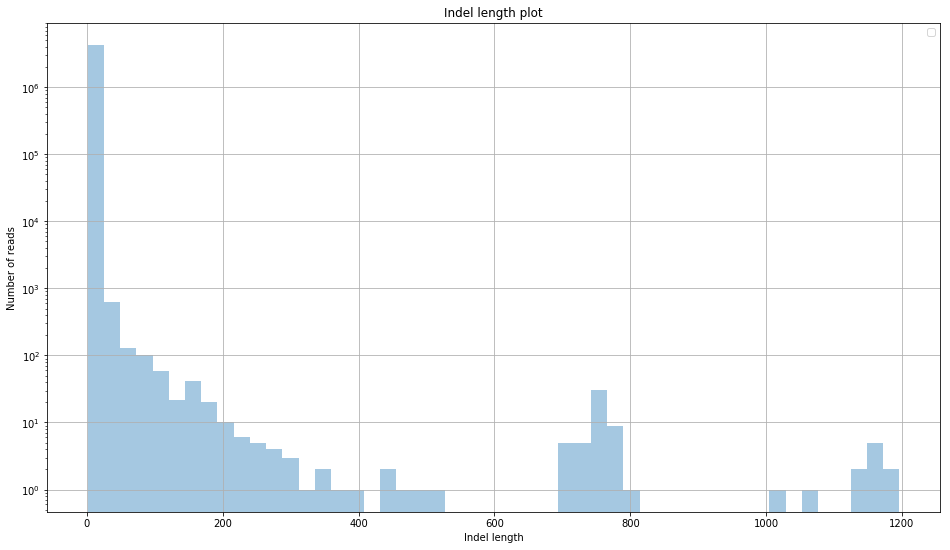

In [49]:
indel_onp = indel_stat(onp_bam_path)
indel_stat_plot(indel_onp)

## PacBio data:

97.37% of reads mapped:

In [50]:
!samtools flagstat Data/Assignment_3/pacb_al_s.bam

49743 + 0 in total (QC-passed reads + QC-failed reads)
1528 + 0 secondary
6768 + 0 supplementary
0 + 0 duplicates
48434 + 0 mapped (97.37% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

4639675


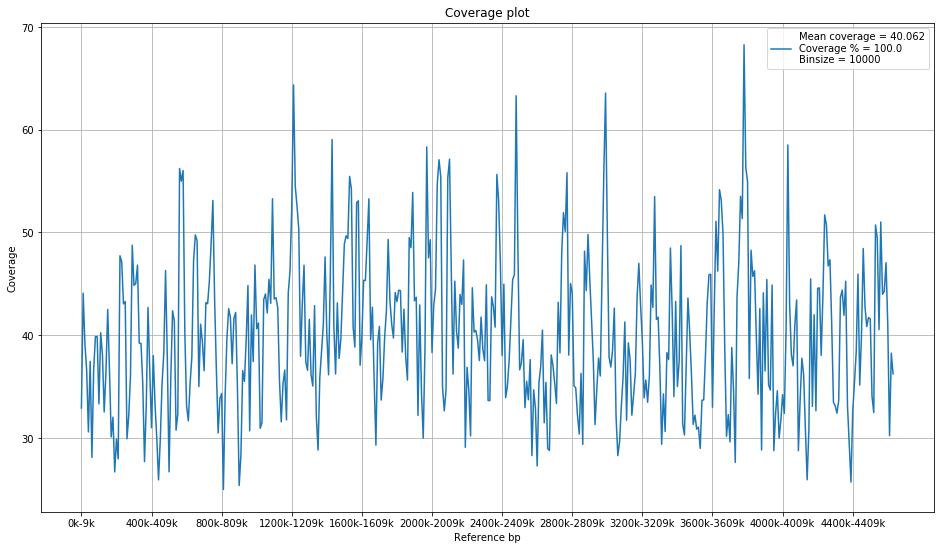

In [51]:
cov_pcb = get_coverage(pacb_bam_path)
print(len(cov_pcb))
coverage_plot(cov_pcb, bin_width=10000, lab_step=40)

In [58]:
print('Mean error percentage =', round(get_mean_error(pacb_bam_path), 3), '%')

Mean error percentage = 12.693 %


In [55]:
%time !mpirun -np 4 python sub_indel_mat_parallel.py -b Data/Assignment_3/pacb_al_s.bam -ref Data/Assignment_3/reference.fasta -o Data/Assignment_3/pacb_subind.csv

CPU times: user 1min 13s, sys: 18.8 s, total: 1min 32s
Wall time: 53min 3s


In [56]:
pd.read_csv('Data/Assignment_3/pacb_subind.csv', index_col=0)

,A,C,G,T,_
A,0.0,457338.0,322254.0,285699.0,7408494.0
C,354487.0,0.0,415583.0,309393.0,8181709.0
G,307539.0,414331.0,0.0,359744.0,8210009.0
T,285427.0,321990.0,450152.0,0.0,7547315.0
_,1439867.0,2074963.0,2067558.0,1436033.0,0.0


/home/dmitry/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


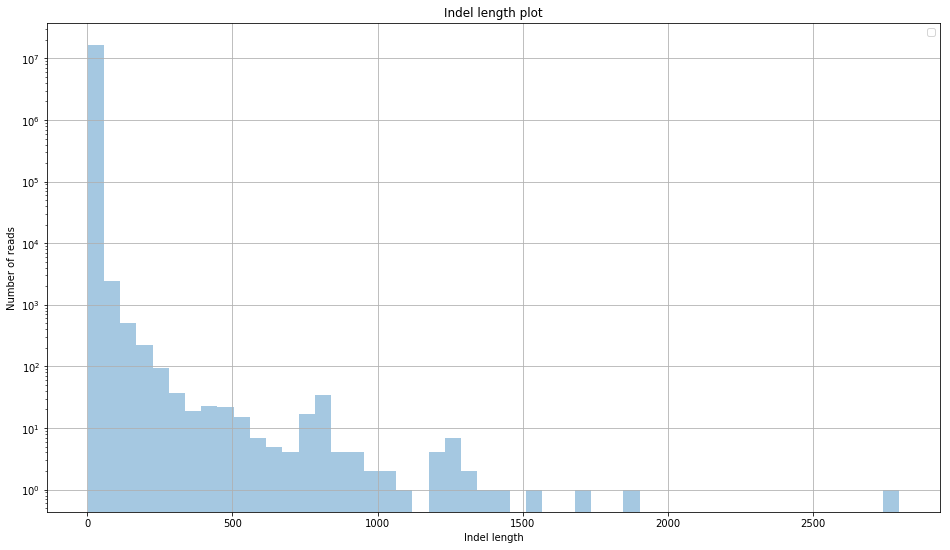

In [54]:
indel_pacb = indel_stat(pacb_bam_path)
indel_stat_plot(indel_pacb)